# TensorFlow Speech Recognition Challenge Code
### Table of Contents:
1. [Imports](#imports)
2. [Read data](#readdata)
3. [Clean/augment wav files](#clean)
4. [Create spectrograms](#specgrams)
5. [Set class weights](#weights)
6. [Train CNN](#cnn)
7. [Predict on test files](#predict)

<a id="imports"></a>
## 1. Imports

In [2]:
import pandas as pd
import numpy as np
import glob
import scipy
import matplotlib.pyplot as plt
import re
import os
import librosa
import IPython.display as ipd
import librosa.display
%matplotlib inline

<a id="readdata"></a>
## 2. Read pickled DataFrames

In [3]:
POSSIBLE_LABELS = 'yes no up down left right on off stop go unknown silence'.split()
id2name = {i: name for i, name in enumerate(POSSIBLE_LABELS)}
name2id = {name: i for i, name in id2name.items()}

In [4]:
train_df = pd.read_pickle('train_df_dec10.pkl')

In [5]:
valid_df = pd.read_pickle('valid_df_dec10.pkl')

In [6]:
train_df.head(1)

,label,label_id,user_id,wav_file,sound
0,left,4,cb8f8307,train/audio/left/cb8f8307_nohash_1.wav,"[-7, 21, -10, 6, -13, 7, 15, -23, 14, -12, 29,..."


In [7]:
train_df.tail(1)

,label,label_id,user_id,wav_file,sound
65122,silence,11,running,train/audio/_background_noise_/running_tap.wav,"[-4884, -1366, 1058, 2169, -2183, 1213, 2858, ..."


In [8]:
valid_df.head(1)

,label,label_id,user_id,wav_file
0,left,4,471a0925,train/audio/left/471a0925_nohash_4.wav


<a id="clean"></a>
## 3. Clean/augment wav files

### Make sure all wavs are exactly 1 sec

In [10]:
def resize_wavs(x):
    length = len(x)
    # if shorter than 16k, pad with zeros
    if length < 16000:
        diff = 16000-length
        ind = np.random.randint(0, diff)
        x = np.pad(x, (ind, 16000-(ind+length)), "constant")
    # if longer than 16k, chop off end
    elif length > 16000:
        x = x[:16000]
    return x

In [11]:
train_df["sound2"] = train_df.sound.apply(resize_wavs)

In [12]:
train_df.head(1)

,label,label_id,user_id,wav_file,sound,sound2
0,left,4,cb8f8307,train/audio/left/cb8f8307_nohash_1.wav,"[-7, 21, -10, 6, -13, 7, 15, -23, 14, -12, 29,...","[-7, 21, -10, 6, -13, 7, 15, -23, 14, -12, 29,..."


### Waves/labels to lists, separate silence files (for now)

In [13]:
sound2 = list(train_df.sound2)
label_id = list(train_df.label_id)

In [14]:
silences = list(train_df[train_df.label_id == 11].sound2)

In [15]:
len(silences)

7200

### Double non-silence training data by smushing, stretching, or adding noise to clips

In [16]:
sound3 = sound2
label_id2 = label_id

In [17]:
# resamples down to 10k, pads shortened clip with noise to return to 16k
def shrink(x):
    x = scipy.signal.resample(x, 10000)
    ind = np.random.randint(0, 6000)
    x = np.pad(x, (ind, 16000-(ind+10000)), "constant")
    sil_ind = np.random.randint(0, len(silences))
    new_x = 0.8*x + 0.2*silences[sil_ind]
    return new_x

# resamples up to 22k, takes middle 16k
def stretch(x):
    x = scipy.signal.resample(x, 22000)
    return x[3000:19000]

# layers in background noise from silence files
def add_noise(x):
    sil_ind = np.random.randint(0, len(silences))
    new_x = 0.7*x + 0.4*silences[sil_ind]
    return new_x

In [23]:
# applies augmentation functions
for i in range(57923):
    if i % 3 == 0:
        new_x = shrink(sound2[i])
        sound3.append(new_x)
        label_id2.append(label_id[i])
    elif i % 3 == 1:
        new_x = stretch(sound2[i])
        sound3.append(new_x)
        label_id2.append(label_id[i])
    elif i % 3 == 2:
        new_x = add_noise(sound2[i])
        sound3.append(new_x)
        label_id2.append(label_id[i])

In [27]:
# import pickle

In [29]:
# pickle.dump(sound3, open('sound3.pkl', 'wb'))

In [30]:
# pickle.dump(label_id2, open("label_id2.pkl", "wb"))

<a id="specgrams"></a>
## 4. Create spectrograms with Librosa

In [18]:
from scipy.io import wavfile

In [32]:
def wav2spec_val(X, max_len = 16000, n_mels = 128):
    """Turns audio into a spectrogram, used on validation data"""
    x_spec = np.zeros((len(X), n_mels, 32, 1))
    for i, fn in enumerate(X):
        _, wave = scipy.io.wavfile.read(fn)
        wave = wave[:max_len]
        wave = np.pad(wave, (0, max_len-wave.shape[0]), 'constant')
        # scales data from -1 to 1
        wave = wave / np.max([np.max(abs(wave)), 0.00001])
        S = librosa.feature.melspectrogram(wave, sr=16000, n_mels=n_mels)
        log_S = librosa.power_to_db(S, ref=np.max)
        x_spec[i,:,:,0] = log_S
    return x_spec

In [33]:
def wav2spec_train(X, max_len = 16000, n_mels = 128):
    """Turns audio into a spectrogram, used on training data"""
    x_spec = np.zeros((len(X), n_mels, 32, 1))
    for i, wave in enumerate(X):
        wave = wave[:max_len]
        wave = np.pad(wave, (0, max_len-wave.shape[0]), 'constant')
        # scales data from -1 to 1
        wave = wave / np.max([np.max(abs(wave)), 0.00001])
        S = librosa.feature.melspectrogram(wave, sr=16000, n_mels=n_mels)
        log_S = librosa.power_to_db(S, ref=np.max)
        x_spec[i,:,:,0] = log_S
    return x_spec

In [36]:
x_train_vec = wav2spec_train(sound3)
x_val_vec = wav2spec_val(valid_df.wav_file)

In [42]:
x_train_vec.shape

(123046, 128, 32, 1)

In [43]:
y_train_vec = np.array(label_id2)
y_val_vec = valid_df.label_id.as_matrix()

In [45]:
y_val_vec.shape

(6798,)

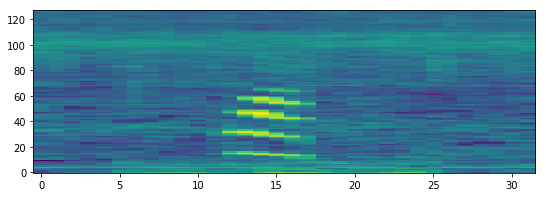

In [47]:
plt.figure(figsize=(9,3))
plt.imshow(x_train_vec[65129,:,:,0], aspect="auto", origin="lower")

In [50]:
np.save('x_train_vec_dec10.npy', x_train_vec)

In [51]:
np.save('y_train_vec_dec10.npy', y_train_vec)

<a id="weights"></a>
## 5. Set class weights

In [68]:
ind, counts = np.unique(y_train_vec, return_counts=True)

In [69]:
counts

array([ 4232,  4210,  4230,  4190,  4212,  4222,  4220,  4202,  4268,
        4224, 73636,  7200])

In [70]:
class_weight = {i: count for i, count in zip(ind, counts)}

In [71]:
class_weight = {ind: len(x_train_vec)/val for ind, val in class_weight.items()}

In [72]:
class_weight

{0: 29.075141776937617,
 1: 29.227078384798101,
 2: 29.088888888888889,
 3: 29.366587112171839,
 4: 29.213200379867047,
 5: 29.14400757934628,
 6: 29.15781990521327,
 7: 29.282722513089006,
 8: 28.829896907216494,
 9: 29.130208333333332,
 10: 1.6710033135966103,
 11: 17.089722222222221}

<a id="cnn"></a>
## 6. Train CNN with Keras

In [73]:
import keras
import keras.backend as K

Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [74]:
num_labels = 12

In [76]:
x_train_vec[0].shape

(128, 32, 1)

In [77]:
model = keras.Sequential([
    keras.layers.InputLayer(input_shape=(128,32,1)),
    keras.layers.Conv2D(64, kernel_size=(20,8), strides=1, padding='same', activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2,2), padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, kernel_size=(10,4), padding='same', activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2,2), padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, kernel_size=(5,2), padding='same', activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2,2), padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, kernel_size=(2,2), padding='same', activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2,2), padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, kernel_size=(2,1), padding='same', activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2,2), padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.Flatten(),
    keras.layers.Dense(500, activation="relu"),
    keras.layers.Dropout(.5),
    keras.layers.Dense(250, activation="relu"),
    keras.layers.Dropout(.4),
    keras.layers.Dense(num_labels, activation="softmax")
])

model.compile(loss='sparse_categorical_crossentropy', 
               optimizer='nadam',
               metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 32, 1)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 32, 64)       10304     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 16, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 16, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 16, 64)        163904    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 8, 64)         0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 8, 64)         256       
__________

In [78]:
from tensorflow.python.keras.callbacks import EarlyStopping

In [79]:
callbacks = [EarlyStopping(monitor='val_loss',
                           patience=5,
                           verbose=1,
                           min_delta=0.01,
                           mode='min')]

In [80]:
history = model.fit(x_train_vec, y_train_vec,
                              batch_size = 256,
                              epochs=50,
                              verbose=1, 
                              callbacks=callbacks,
                              validation_data=(x_val_vec, y_val_vec),
                              class_weight = class_weight)

Train on 123046 samples, validate on 6798 samples
Epoch 1/50
123046/123046 [==============================] - 187s 2ms/step - loss: 16.1380 - acc: 0.4163 - val_loss: 0.8133 - val_acc: 0.7224
Epoch 2/50
123046/123046 [==============================] - 179s 1ms/step - loss: 8.9434 - acc: 0.6521 - val_loss: 0.5923 - val_acc: 0.8008
Epoch 3/50
123046/123046 [==============================] - 179s 1ms/step - loss: 7.2433 - acc: 0.7221 - val_loss: 0.4908 - val_acc: 0.8455
Epoch 4/50
123046/123046 [==============================] - 179s 1ms/step - loss: 6.3200 - acc: 0.7556 - val_loss: 0.3619 - val_acc: 0.8773
Epoch 5/50
123046/123046 [==============================] - 179s 1ms/step - loss: 5.7280 - acc: 0.7768 - val_loss: 0.3583 - val_acc: 0.8792
Epoch 6/50
123046/123046 [==============================] - 179s 1ms/step - loss: 5.3283 - acc: 0.7951 - val_loss: 0.7126 - val_acc: 0.7673
Epoch 7/50
123046/123046 [==============================] - 179s 1ms/step - loss: 5.0806 - acc: 0.8017 - val_

In [81]:
y_val_pred = model.predict(x_val_vec)

In [82]:
y_val_pred[0]

array([  2.78599282e-06,   6.80228762e-09,   6.94566182e-10,
         2.62370015e-10,   9.99930024e-01,   4.64455585e-09,
         3.23929328e-10,   2.21292602e-08,   6.14031959e-12,
         1.55445823e-10,   6.71811795e-05,   9.41062441e-22], dtype=float32)

In [83]:
y_val_pred2 = np.array([np.argmax(pred) for pred in y_val_pred])

In [84]:
y_val_pred_label = np.vectorize(id2name.get)(y_val_pred2)

In [85]:
val_df = pd.Series(y_val_pred_label)

In [86]:
val_df.value_counts()

unknown    3701
right       372
no          344
left        321
go          309
down        304
up          300
yes         295
on          289
stop        274
off         272
silence      17
dtype: int64

<a id="predict"></a>
## 7. Predict on test files

In [87]:
test_files = glob.glob('test/audio/*wav')

In [88]:
test_files[:10]

['test/audio/clip_bd6d0fb25.wav',
 'test/audio/clip_3e7a56353.wav',
 'test/audio/clip_c5884a6cb.wav',
 'test/audio/clip_ebf0d1f7b.wav',
 'test/audio/clip_2f714f052.wav',
 'test/audio/clip_05bfe5e6a.wav',
 'test/audio/clip_317b4a205.wav',
 'test/audio/clip_292983fee.wav',
 'test/audio/clip_e086bfc8e.wav',
 'test/audio/clip_d0d7fa566.wav']

In [89]:
x_test = wav2spec_val(test_files)

In [104]:
np.save('x_test_processed_dec10_1.npy', x_test)

In [53]:
# x_test = np.load('x_test_processed_dec7_normal_1.npy')

In [90]:
x_test.shape

(158538, 128, 32, 1)

In [91]:
y_test_pred = model.predict(x_test)

In [92]:
y_test_pred[1]

array([  7.25300363e-23,   1.21090929e-18,   2.44212151e-19,
         3.69178681e-17,   3.61696769e-19,   2.43067486e-16,
         9.99993563e-01,   1.40492750e-12,   7.19334570e-24,
         7.29242097e-17,   6.39184236e-06,   4.95808185e-36], dtype=float32)

In [93]:
y_test_pred2 = np.array([np.argmax(pred) for pred in y_test_pred])

In [94]:
y_test_pred2.shape

(158538,)

In [95]:
y_test_pred_label = np.vectorize(id2name.get)(y_test_pred2)

In [96]:
labels_df = pd.Series(y_test_pred_label)

In [97]:
labels_df.value_counts()

unknown    64764
silence    11985
right      10235
left        9886
go          9394
no          9063
on          7794
yes         7651
up          7479
off         7176
stop        6772
down        6339
dtype: int64

In [98]:
y_test_pred_label.shape

(158538,)

In [99]:
y_test_pred_label[:10]

array(['no', 'on', 'no', 'right', 'off', 'yes', 'right', 'silence', 'off',
       'right'],
      dtype='<U7')

In [100]:
test_files2 = [file.replace('test/audio/', "") for file in test_files]

In [101]:
test_files2[:10]

['clip_bd6d0fb25.wav',
 'clip_3e7a56353.wav',
 'clip_c5884a6cb.wav',
 'clip_ebf0d1f7b.wav',
 'clip_2f714f052.wav',
 'clip_05bfe5e6a.wav',
 'clip_317b4a205.wav',
 'clip_292983fee.wav',
 'clip_e086bfc8e.wav',
 'clip_d0d7fa566.wav']

### Write predicted labels to file

In [102]:
with open('ccmm_submission_dec10_1.csv', 'w') as fout:
    fout.write('fname,label\n')
    for i in range(len(y_test_pred_label)):
        fout.write('{},{}\n'.format(test_files2[i], y_test_pred_label[i]))

In [103]:
model.save('model_dec10_5CNNs_melpower_noise.h5')